$$\min_x f(x) \quad\text{subject to} \quad h(x)\leq0, Ax=b.$$

In [25]:
import numpy as np
from sympy import *

In [26]:
x1, x2 = symbols('x1 x2')

# Define the function
f = 1/2*(10*x1**2+x2**2)+5*log(1+exp(-x1-x2))

# evaluate the function
evalf = lambdify([x1,x2], f, 'numpy')

# Define the constraint
A = Matrix([[1,1]])
b = Matrix([2])

# Define the inequality constraint
h = x1 + x2 - 3
phi = -log(-h)

# Construct a large matrix by stacking the constraint matrix
# and the hessian matrix
def direction(x, f=f, A=A):
    gradf = Matrix([diff(f,x1),diff(f,x2)])
    hessf = Matrix([[diff(f,x1,x1),diff(f,x1,x2)],[diff(f,x2,x1),diff(f,x2,x2)]])
    
    if A:
        zero_shape = A.shape[0]
        LHS = np.array(N(Matrix([[hessf, A.T],[A, zeros(zero_shape, zero_shape)]]).subs({x1:x[0], x2:x[1]}))).astype(np.float64)
        RHS = np.array(N(Matrix([-gradf, zeros(zero_shape, 1)]).subs({x1:x[0], x2:x[1]}))).astype(np.float64)
    else:
        LHS = np.array(N(hessf.subs({x1:x[0], x2:x[1]}))).astype(np.float64)
        RHS = np.array(N(-gradf.subs({x1:x[0], x2:x[1]}))).astype(np.float64)
    
    # Solve the linear system
    sol = np.linalg.solve(LHS, RHS).reshape(-1)
    return sol[:x.shape[0]]


def central_path(f=f, phi=phi, A=A, b=b, x0=np.array([1,0]), t0=10, tol=1e-8, max_iter=100, step = 1, miu=10):
    t0 = 10
    x = x0
    t = t0
    path = [x]
    while True:
        min_func = t*f + phi
        while True:
            # Inner Newton's method
            v = direction(x, f=min_func, A=A)
            while True:
                # This is the backtracking line search to make sure the constraint is satisfied
                x_new = x + step*v
                temp = min_func.subs({x1:x_new[0], x2:x_new[1]})
                if temp.is_real:
                    break
                else:
                    step = step*0.8
            if np.linalg.norm(v) < tol:
                break
            else:
                print('v', v)
                x = x_new
        path.append(x)
        t = t*miu
        step = 1
        x = x_new
        if t > 1/tol:
            break
    return x, path
        

In [27]:
x, path = central_path(x0=np.array([0.5,0.5]))

v [-0.40909091  0.40909091]


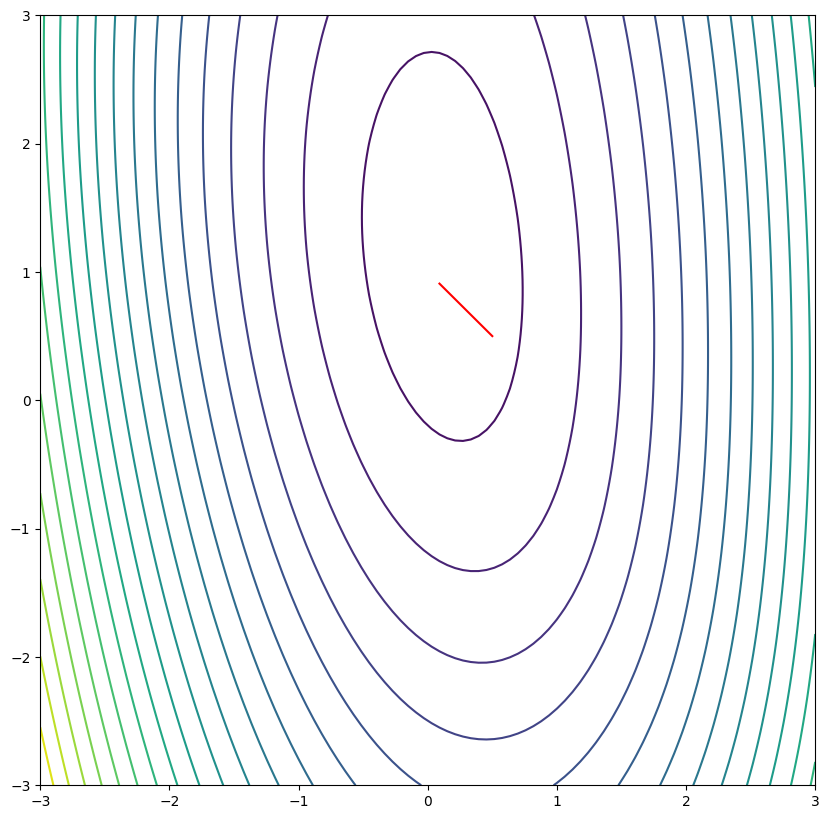

In [28]:
# evaluate the function on a grid
x1_grid = np.linspace(-3,3,100)
x2_grid = np.linspace(-3,3,100)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
f_grid = evalf(x1_grid, x2_grid)

# plot the path and contour
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.contour(x1_grid, x2_grid, f_grid, 20)
plt.plot([x[0] for x in path], [x[1] for x in path], 'r-')
plt.show()